# SegMate Demo Notebook

Welcome to the SegMate demo notebook! In this notebook, we will showcase the capabilities of SegMate, a Segment Anything Model Toolkit developed by AI Engineering team at Vector Institute.

## SegMate: A Segment Anything Model Toolkit

SegMate is a powerful toolkit that utilizes the Segment Anything Model (SAM) developed by Meta AI. SAM is a promptable segmentation system capable of accurately "cutting out" any object from an image with just a single click. It exhibits zero-shot generalization to unfamiliar objects and images, eliminating the need for additional training.

## SAM Architecture

SAM utilizes a sophisticated architecture comprising three key components: the image encoder, the prompt encoder, and the mask decoder.

- **Image Encoder**: Captures essential features from the input image, extracting high-level representations that encode relevant information about objects and their context. This step allows SAM to understand the visual content of the image.

- **Prompt Encoder**: Processes user-provided prompts, such as bounding boxes, points, or text, and transforms them into meaningful representations. These representations guide SAM to understand the desired object to be segmented.

- **Mask Decoder**: Generates precise segmentation masks by leveraging the encoded information from both the image encoder and the prompt encoder. It efficiently processes the features and produces detailed object boundaries, enabling near real-time segmentation results.

Let's start by importing the necessary libraries:

In [1]:
from segmate.segmate import SegMate
import segmate.utils as utils
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

/scratch/ssd004/scratch/vkhazaie/sam/lib/python3.9/site-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


### Initializing SegMate

To start using SegMate, we need to create an instance of the SegMate class. Here, we create an instance called `sm` with the following parameters:

- `model_type`: Specifies the type of model to use. In this case, we are using the `vit_b` model. The options are `vit_b`, `vit_l` and `vit_h`.
- `checkpoint`: Specifies the path to the checkpoint file that contains the pre-trained weights of the model.
- `device`: Specifies the device to run the model on. In this case, we are using the `cuda` device for GPU acceleration.
- `object_detector`: Optional parameter that allows you to provide a custom object detector when you want to use the model with text prompt. If not specified, the default object detector is `None`. You can always add the `object_detector` later.

This instance of the SegMate class serves as our toolkit for performing segmentation tasks with SAM. It encapsulates the model and provides convenient methods for inference and fine-tuning.

Let's create the instance and load the model:

In [2]:
model_checkpoint = '/ssd003/projects/aieng/image_models/sam_vit_b.pth'

In [3]:
sm = SegMate(model_type='vit_b', checkpoint=model_checkpoint, device='cuda', object_detector=None)

### Using Building Image Segmentation Dataset

In this section, we will demonstrate how to load and utilize the Building Image Segmentation dataset, which is available in the HuggingFace datasets library. We will load the mini version of the dataset and retrieve the bounding box, segmentation mask, and image of a sample from the training set.

To begin, we import the necessary libraries and load the dataset using the `load_dataset()` function from the HuggingFace🤗 datasets library:

In [4]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

### Training a custom decoder for Building Image Segmentation Dataset

In this section, we will demonstrate how to create a PyTorch Dataset instance from the Building Image Segmentation (BIS) dataset and train a custom decoder on this dataset using the SegMate toolkit.

Let's take a look at the code snippet:

In [5]:
from segmate.dataset import BISDataset
from tqdm import tqdm
bis_dataset = BISDataset(dataset=dataset['train'],
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)

In [6]:
bis_dataloader = sm.get_dataset(bis_dataset)

In [7]:
# class SegmentationDecoder(nn.Module):
#     def __init__(self, in_channels=256):
#         super(SegmentationDecoder, self).__init__()

#         # Upsampling layers
#         self.upconv1 = nn.ConvTranspose2d(in_channels, 128, kernel_size=4, stride=2, padding=1)
#         self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
#         self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
#         self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=1, padding=1)
        
#         # Final convolution to reach the desired number of channels (1)
#         self.final_conv = nn.Conv2d(16, 1, kernel_size=14)

#     def forward(self, x):
#         x = self.upconv1(x)
#         x = self.upconv2(x)
#         x = self.upconv3(x)
#         x = self.upconv4(x)
#         x = self.final_conv(x)

#         return x


class SegmentationDecoder(nn.Module):
    def __init__(self, in_channels=256):
        super(SegmentationDecoder, self).__init__()

        # Upsampling layers
        self.upconv1 = nn.ConvTranspose2d(in_channels, 128, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU()

        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.upconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        self.upconv4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # Final convolution to reach the desired number of channels (1)
        self.final_conv = nn.Conv2d(16, 1, kernel_size=14)

        # Sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.upconv1(x)
        x = self.relu1(x)

        x = self.upconv2(x)
        x = self.relu2(x)

        x = self.upconv3(x)
        x = self.relu3(x)

        x = self.upconv4(x)
        x = self.relu4(x)

        x = self.final_conv(x)

#         # Apply sigmoid activation to the output
        x = self.sigmoid(x)

        return x

In [8]:
decoder = SegmentationDecoder(in_channels=256)
decoder.to(sm.device)

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (upconv4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (final_conv): Conv2d(16, 1, kernel_size=(14, 14), stride=(1, 1))
  (sigmoid): Sigmoid()
)

In [9]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Binary Cross Entropy Loss with logits
optimizer = optim.Adam(decoder.parameters(), lr=0.001)  # Adam optimizer
decoder.train()  # Set the decoder to training mode

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    n = 0
    for input_image, _, gt_mask in tqdm(bis_dataloader):
        if n > 10:
            break
        if gt_mask.shape[2:] == (500, 500):
            optimizer.zero_grad()

            # Forward pass
            features = sm.sam.image_encoder(input_image)
            output_mask = decoder(features)

            # Calculate the loss            
            gt_mask = (gt_mask - gt_mask.min()) / (gt_mask.max() - gt_mask.min())
#             output_mask = (output_mask - output_mask.min()) / (output_mask.max() - output_mask.min())
            loss = criterion(output_mask, gt_mask)
            print(gt_mask.max())
            print(gt_mask.min())
            
            print(output_mask.max())
            print(output_mask.min())

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            n = n + 1
        

    epoch_loss = running_loss / n
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5008, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4984, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:03<5:50:12,  3.11s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4898, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4871, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:04<3:41:16,  1.96s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4756, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4686, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:05<2:04:32,  1.11s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4503, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4179, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:06<1:37:12,  1.16it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4096, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.3050, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:07<1:45:31,  1.07it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3136, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.1187, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:08<1:51:57,  1.01it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.1922, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0230, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:10<45:42,  2.46it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.2160, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0171, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 15/6764 [00:11<59:58,  1.88it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.1770, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0155, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:12<54:14,  2.07it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.2338, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0189, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:13<1:07:01,  1.68it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.1847, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0190, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:15<1:20:48,  1.39it/s]


Epoch [1/20] - Loss: 0.1610


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3031, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0268, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:11:34,  1.17s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.2515, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0320, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:11:14,  1.16s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.2947, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0510, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:32:03,  1.22it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3254, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0658, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:04<1:20:24,  1.40it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3247, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0746, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:05<1:33:44,  1.20it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3312, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0717, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:43:58,  1.08it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3566, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0837, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<43:38,  2.58it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3495, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0785, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 15/6764 [00:09<58:44,  1.91it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3662, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0745, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:10<54:08,  2.08it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3699, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0702, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:06:55,  1.68it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3482, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0301, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:11:22,  1.57it/s]


Epoch [2/20] - Loss: 0.0882


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3648, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0162, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:12:58,  1.18s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3555, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0086, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:12:52,  1.18s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3567, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0049, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:33:42,  1.20it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3556, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0033, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:04<1:21:45,  1.38it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3555, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0016, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:34:55,  1.19it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3626, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0015, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:45:18,  1.07it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3732, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0032, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<44:16,  2.54it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3828, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0037, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 15/6764 [00:09<59:34,  1.89it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.3920, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0078, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<54:42,  2.06it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4004, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0234, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:08:00,  1.65it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4012, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0086, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:12:25,  1.55it/s]


Epoch [3/20] - Loss: 0.0764


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4073, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0082, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:15:28,  1.20s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4092, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0110, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:15:06,  1.20s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4109, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0042, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:34:19,  1.19it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4095, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0024, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:04<1:22:21,  1.37it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4091, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0004, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:35:56,  1.17it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4078, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:46:38,  1.06it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4122, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<44:46,  2.51it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4172, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.7871e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:09<1:00:14,  1.87it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4249, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(7.7233e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<55:23,  2.03it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4301, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0004, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 20/6764 [00:12<1:04:00,  1.76it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4331, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.9682e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:15,  1.49it/s]


Epoch [4/20] - Loss: 0.0708


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4381, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.8804e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:16:56,  1.21s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4418, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0003, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:16:38,  1.21s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4466, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:35:26,  1.18it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4493, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:26,  1.32it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4530, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:38:26,  1.14it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4558, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:48:44,  1.04it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4591, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<45:23,  2.48it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4627, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:00:44,  1.85it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4668, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<55:52,  2.01it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4701, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0011, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:09:15,  1.62it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4722, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:14:11,  1.51it/s]


Epoch [5/20] - Loss: 0.0637


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4745, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:17:42,  1.22s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4764, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0008, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:17:28,  1.22s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4782, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0005, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:36:21,  1.17it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4802, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0003, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:04<1:24:20,  1.34it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4817, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.3626e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:37:43,  1.15it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4831, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(7.9127e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▍                                                                                                                                                                                                                                                                                                                      | 9/6764 [00:07<1:24:10,  1.34it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4848, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.2367e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<42:33,  2.64it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4872, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.8553e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 16/6764 [00:10<51:43,  2.17it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4891, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<57:24,  1.96it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4904, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0010, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:11:26,  1.57it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4914, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:03,  1.50it/s]


Epoch [6/20] - Loss: 0.0608


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4925, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:17:15,  1.22s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4934, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0004, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:17:17,  1.22s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4942, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0005, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:35:39,  1.18it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4951, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:04<1:23:27,  1.35it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4958, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.9380e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:37:00,  1.16it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4963, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.3091e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:47:39,  1.05it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4975, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.7602e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<45:09,  2.49it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.4988, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.0043e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:09<1:00:40,  1.85it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5001, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.1617e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<55:44,  2.02it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5004, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(7.5686e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:09:08,  1.63it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5006, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.7532e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:13:53,  1.52it/s]


Epoch [7/20] - Loss: 0.0591


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5007, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.1332e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:17:48,  1.22s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5008, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.7040e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:17:33,  1.22s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5008, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.8796e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:36:06,  1.17it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5009, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.9314e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:04<1:23:58,  1.34it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5010, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.1154e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:38:44,  1.14it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5010, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.3890e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:48:51,  1.03it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5011, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.1590e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<45:25,  2.48it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5011, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.4131e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 17/6764 [00:10<43:34,  2.58it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5013, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.1031e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 18/6764 [00:11<1:02:39,  1.79it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5014, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.2910e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:18:40,  1.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5014, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.9968e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:00,  1.50it/s]


Epoch [8/20] - Loss: 0.0566


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5016, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.1832e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:18:27,  1.23s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5017, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.9862e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:18:15,  1.23s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5019, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.5098e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:36:36,  1.17it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5019, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.9007e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:04<1:24:24,  1.33it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5019, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.0480e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:38:33,  1.14it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5024, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.7963e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:49:21,  1.03it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5025, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(7.4897e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<45:47,  2.46it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5021, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.2467e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:01:36,  1.83it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5026, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.2388e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<56:27,  1.99it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5030, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.8774e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:09:55,  1.61it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5026, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.4087e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:13<1:14:47,  1.50it/s]


Epoch [9/20] - Loss: 0.0550


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5031, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.5097e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:19:15,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5031, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.6857e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:18:44,  1.23s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5035, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.6776e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:37:05,  1.16it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5032, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.5653e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:24:41,  1.33it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5029, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.0489e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:38:25,  1.14it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5037, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.4053e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:49:13,  1.03it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5038, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.1196e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<45:51,  2.45it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5032, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.7753e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:01:37,  1.83it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5041, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.5303e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<56:34,  1.99it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5043, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.6137e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:13,  1.60it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5040, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.9773e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:14:58,  1.50it/s]


Epoch [10/20] - Loss: 0.0544


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5045, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.3080e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:19:57,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5043, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.8655e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:19:37,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5052, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.5417e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:37:24,  1.16it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5046, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.7487e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:13,  1.32it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5044, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.2355e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:38:59,  1.14it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5055, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.2582e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▍                                                                                                                                                                                                                                                                                                                     | 10/6764 [00:07<1:05:51,  1.71it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5052, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.2822e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<43:51,  2.57it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5044, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.1445e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 16/6764 [00:10<53:07,  2.12it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5057, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.0686e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<58:53,  1.91it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5060, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.4103e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:13:37,  1.53it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5055, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.4850e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:44,  1.48it/s]


Epoch [11/20] - Loss: 0.0543


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5067, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.6640e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:19:44,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5058, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.1844e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:19:04,  1.23s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5072, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.3843e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:37:37,  1.15it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5063, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.0941e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:30,  1.32it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5055, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.4451e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:39:47,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5072, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.6352e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:50:44,  1.02it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5071, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.0481e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:18,  2.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5056, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.3777e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:12,  1.81it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5067, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.9532e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<57:05,  1.97it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5080, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.3907e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:49,  1.59it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5071, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.3230e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:37,  1.49it/s]


Epoch [12/20] - Loss: 0.0553


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5089, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.0182e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:21:08,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5075, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.4096e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 3/6764 [00:02<1:26:01,  1.31it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5105, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.4705e-05, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:47:50,  1.04it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5088, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.2932e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:28:51,  1.27it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5080, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.4115e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:42:56,  1.09it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5112, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0705e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:53:18,  1.01s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5107, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.2047e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:04,  2.44it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5070, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.4038e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:23,  1.80it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5093, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0937e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<57:03,  1.97it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5116, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.7562e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:46,  1.59it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5089, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.8842e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:16:25,  1.47it/s]


Epoch [13/20] - Loss: 0.0531


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5124, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.2481e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:20:29,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5097, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.4406e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:19:40,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5165, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.3353e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:37:51,  1.15it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5131, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.4430e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:20,  1.32it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5120, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.0150e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:39:20,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5177, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.5018e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:51:42,  1.01it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5167, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.8266e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:26,  2.42it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5106, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.4475e-08, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:28,  1.80it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5141, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.9805e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<57:17,  1.96it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5147, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.1346e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:11:02,  1.58it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5122, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.2928e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:54,  1.48it/s]


Epoch [14/20] - Loss: 0.0513


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5160, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(8.4695e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:21:27,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5123, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.6203e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:20:39,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5182, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.7089e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:38:19,  1.15it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5148, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.9134e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:38,  1.32it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5124, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.9806e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:39:42,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5201, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(7.4457e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:50:37,  1.02it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5195, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.4741e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:21,  2.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5126, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.8604e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:08,  1.81it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5168, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.7818e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<56:58,  1.97it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5190, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.8155e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:46,  1.59it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5148, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.3062e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:45,  1.48it/s]


Epoch [15/20] - Loss: 0.0502


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5178, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.0673e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:20:07,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5135, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0193e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:21:49,  1.26s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5208, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.1940e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:38:24,  1.14it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5177, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.5857e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:53,  1.31it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5137, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.7139e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:39:58,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5234, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(8.2483e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:50:39,  1.02it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5217, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.2892e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:20,  2.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5152, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.5252e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:21,  1.80it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5206, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.3097e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<57:06,  1.97it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5189, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0889e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:59,  1.58it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5172, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.6904e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:49,  1.48it/s]


Epoch [16/20] - Loss: 0.0489


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5214, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.6188e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:20:01,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5164, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.4021e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:19:54,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5213, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.5362e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:37:58,  1.15it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5188, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.2373e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:34,  1.32it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5141, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.2976e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:39:27,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5256, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.1154e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:50:04,  1.02it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5239, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.9214e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:08<46:12,  2.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5175, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.9468e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:01:57,  1.82it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5222, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.8554e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<56:59,  1.97it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5226, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.1644e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:51,  1.59it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5216, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.4411e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:35,  1.49it/s]


Epoch [17/20] - Loss: 0.0485


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5253, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.6558e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:21:01,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5185, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.1178e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:20:39,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5251, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.5383e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:39:51,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5217, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.7475e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:27:17,  1.29it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5166, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(8.1911e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:40:43,  1.12it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.2637e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:51:23,  1.01it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5272, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.9621e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:14,  2.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5229, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.4850e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:06,  1.81it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5288, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.8247e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<56:54,  1.98it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5286, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.1664e-06, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:52,  1.59it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5319, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.4386e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:55,  1.48it/s]


Epoch [18/20] - Loss: 0.0469


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5376, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.9145e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:19:54,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5337, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0645e-12, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:19:50,  1.24s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5431, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.6974e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:38:00,  1.15it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5483, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.7994e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:41,  1.31it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5510, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.6619e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:39:25,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.5810, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.3720e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:50:32,  1.02it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6030, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.9666e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:21,  2.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6382, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.0705e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:18,  1.81it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.6879, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.9308e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<57:02,  1.97it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7193, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.0689e-07, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:12<1:10:46,  1.59it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7019, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.0366e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:15:39,  1.49it/s]


Epoch [19/20] - Loss: 0.0441


  0%|                                                                                                                                                                                                                                                                                                                                 | 0/6764 [00:00<?, ?it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7156, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.9671e-14, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 1/6764 [00:01<2:21:17,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7340, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.1418e-15, device='cuda:0', grad_fn=<MinBackward1>)


  0%|                                                                                                                                                                                                                                                                                                                       | 2/6764 [00:02<2:20:20,  1.25s/it]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7500, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.9070e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▏                                                                                                                                                                                                                                                                                                                      | 4/6764 [00:03<1:38:12,  1.15it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7773, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.3980e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 6/6764 [00:05<1:25:31,  1.32it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.7641, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.2958e-11, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 7/6764 [00:06<1:39:32,  1.13it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8368, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.7704e-10, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▎                                                                                                                                                                                                                                                                                                                      | 8/6764 [00:07<1:50:20,  1.02it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8630, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.2011e-12, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                       | 14/6764 [00:09<46:14,  2.43it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8670, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.0150e-13, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▋                                                                                                                                                                                                                                                                                                                     | 15/6764 [00:10<1:02:12,  1.81it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8962, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(7.6588e-12, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                       | 18/6764 [00:11<57:08,  1.97it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.9105, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.6276e-09, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▊                                                                                                                                                                                                                                                                                                                     | 19/6764 [00:13<1:17:07,  1.46it/s]

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.8717, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.4814e-12, device='cuda:0', grad_fn=<MinBackward1>)


  0%|▉                                                                                                                                                                                                                                                                                                                     | 21/6764 [00:14<1:17:27,  1.45it/s]

Epoch [20/20] - Loss: 0.0364


In [46]:
torch.save(decoder.state_dict(), "../../decoder.pth")

In [122]:
dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

test_bis_dataset = BISDataset(dataset=dataset['test'],
                         preprocess=sm.sam.preprocess,
                         img_size=sm.sam.image_encoder.img_size,
                         device=sm.device)
test_bis_dataloader = sm.get_dataset(test_bis_dataset)

In [123]:
# Set the decoder to evaluation mode
decoder.eval()

SegmentationDecoder(
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU()
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (upconv3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (upconv4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (final_conv): Conv2d(16, 1, kernel_size=(14, 14), stride=(1, 1))
  (sigmoid): Sigmoid()
)

In [124]:
for input_image, _, gt_mask in tqdm(test_bis_dataloader):
    with torch.no_grad():
        features = sm.sam.image_encoder(input_image)
        output_mask = decoder(features)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.24it/s]


In [125]:
from torch.nn import functional as F

# Apply a threshold to get the binary mask
thresholded_mask = F.threshold(output_mask, 0.5, 0)
binary_mask = F.normalize(thresholded_mask)

# Convert the binary mask tensor to a numpy array and remove the batch dimension
binary_mask = binary_mask.squeeze(0).cpu().numpy()

In [126]:
binary_mask.shape

(1, 500, 500)

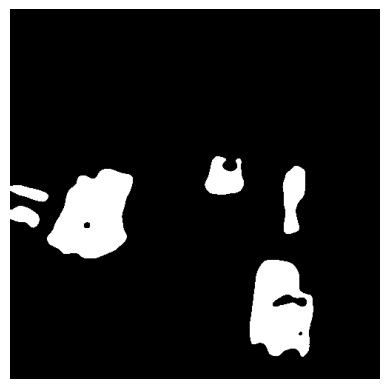

In [127]:
utils.show_image(binary_mask.reshape(500, 500))

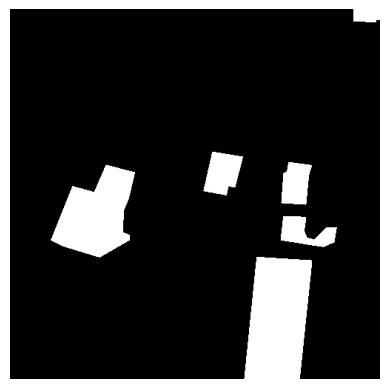

In [128]:
utils.show_image(gt_mask.cpu().numpy().reshape(500, 500))

In [147]:
from segment_anything.utils.transforms import ResizeLongestSide
dataset = load_dataset("keremberke/satellite-building-segmentation", "full")

idx = 12

item = dataset["test"][idx]
image = item["image"]
np_image = np.array(item["image"])
size = np_image.shape[0]

# prepare the image for the model
transform = ResizeLongestSide(1024)
input_image = transform.apply_image(np_image)
input_image = torch.as_tensor(input_image, device=sm.device)
input_image = input_image.permute(2, 0, 1).contiguous()[None, :, :, :]

# preprocess the image
input_image = sm.sam.preprocess(input_image).squeeze()

with torch.no_grad():
    features = sm.sam.image_encoder(input_image.reshape(1, 3, 1024, 1024))
    output_mask = decoder(features)

# get the ground truth segmentation mask
gt_mask = utils.get_segmentation_mask(item["objects"]['segmentation'], size)
gt_mask = gt_mask.reshape((1, 1, size, size)).astype('float32')

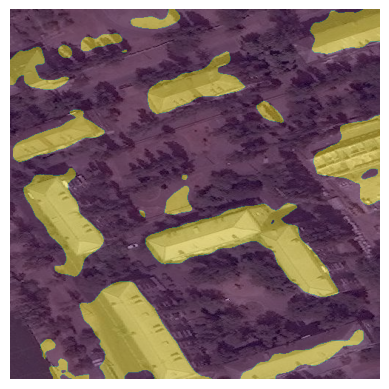

In [148]:
from torch.nn import functional as F

# Apply a threshold to get the binary mask
thresholded_mask = F.threshold(output_mask, 0.4, 0)
binary_mask = F.normalize(thresholded_mask)

# Convert the binary mask tensor to a numpy array and remove the batch dimension
binary_mask = binary_mask.squeeze(0).cpu().numpy()
binary_mask = np.expand_dims(binary_mask, axis=0)
utils.show_masks(np_image, binary_mask)

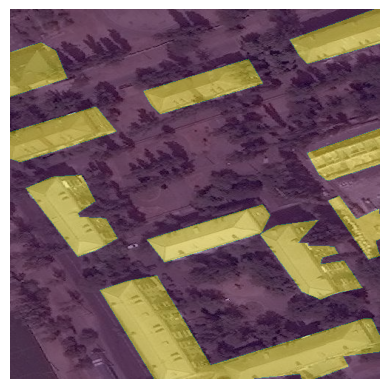

In [149]:
utils.show_masks(np_image, gt_mask)